In [43]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from sklearn.metrics import classification_report
from src.utils import (plot_confusion_matrix, 
                        line_label_id2label, 
                        line_label_label2id, 
                        line_label_token_id2label, 
                        plot_embeddings, 
                        get_df_classificationreport)

import pandas as pd

import torch

# MedBERT Finetune on Lines

In [23]:
results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_test.pt")
y_true = results["labels"]
last_hidden_state = results["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
y_pred = results["preds"]

In [7]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

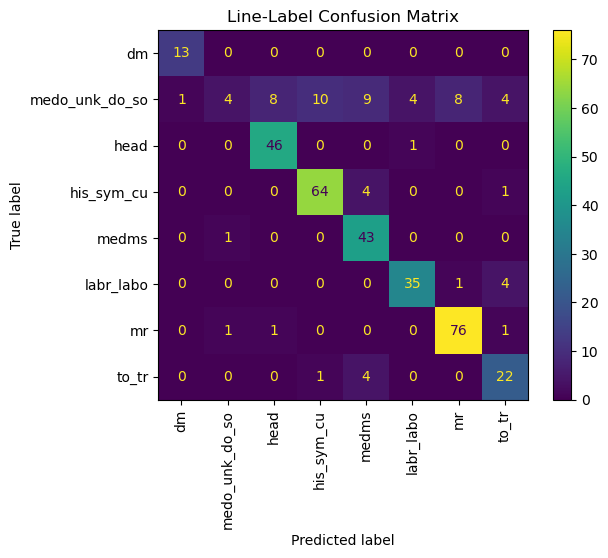

In [8]:
plot_confusion_matrix(preds=y_pred, labels=y_true, title="Line-Label Confusion Matrix", label2id=line_label_label2id)

In [9]:
line_label_id2label

{0: 'dm',
 1: 'medo_unk_do_so',
 2: 'head',
 3: 'his_sym_cu',
 4: 'medms',
 5: 'labr_labo',
 6: 'mr',
 7: 'to_tr'}

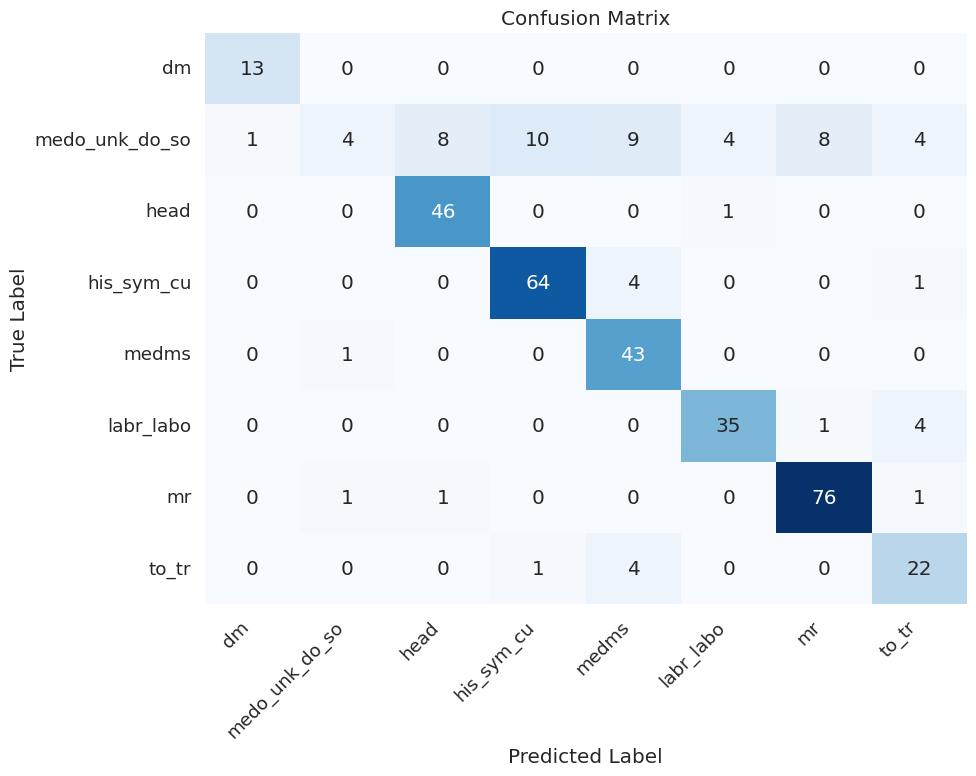

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def pretty_confusion_matrix(y_true, y_pred, labels):
    # Create the confusion matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.set_theme(font_scale=1.2)  # Adjust font size for labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                yticklabels=labels, xticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Get the labels for better display
display_labels = list(line_label_id2label.values())

pretty_confusion_matrix(y_true, y_pred, display_labels)


In [11]:
y_valid = [line_label_id2label[label] for label in y_true]
y_pred = [line_label_id2label[pred] for pred in y_pred]
get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.84,0.98,0.90,47
2,his_sym_cu,0.85,0.93,0.89,69
3,labr_labo,0.88,0.88,0.88,40
4,medms,0.72,0.98,0.83,44
5,medo_unk_do_so,0.67,0.08,0.15,48
6,mr,0.89,0.96,0.93,79
7,to_tr,0.69,0.81,0.75,27
8,accuracy,NaN,NaN,0.83,367
9,macro avg,0.81,0.83,0.78,367


(367, 2)


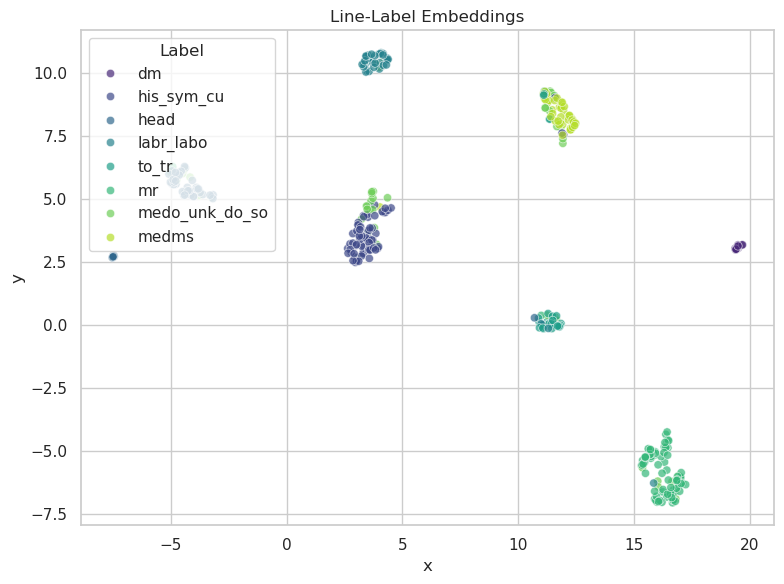

In [12]:
plot_embeddings(embeddings, [line_label_id2label[label] for label in y_true], title="Line-Label Embeddings", method="umap", )

In [13]:
# Analysis of FP and TP
# results.pop("last_hidden_state")
# results_df = pd.DataFrame(results)
# results_df.replace(line_label_id2label, inplace = True)

In [14]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_colwidth', None)
# results_df[results_df["preds"] != results_df["labels"]]

In [15]:
# results_df[results_df["labels"] == "head"]

# MedBERT Token Classification

In [16]:
results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test.pt")

In [20]:
labels, preds = [], []
for obs in results:
    labels.extend(obs["labs"])
    preds.extend(obs["preds"])
y_true = [line_label_label2id[label] for label in labels]
y_pred = [line_label_label2id[pred] for pred in preds]


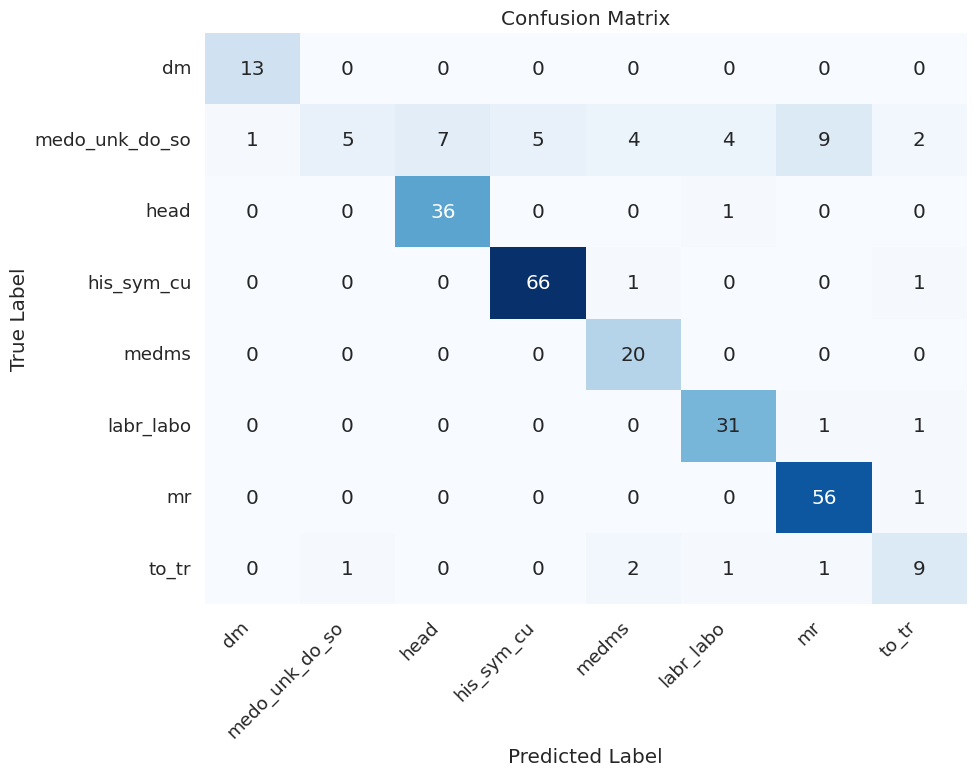

In [21]:
pretty_confusion_matrix(y_true, y_pred, display_labels)

In [22]:
get_df_classificationreport(labels, preds, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.84,0.97,0.90,37
2,his_sym_cu,0.93,0.97,0.95,68
3,labr_labo,0.84,0.94,0.89,33
4,medms,0.74,1.00,0.85,20
5,medo_unk_do_so,0.83,0.14,0.23,37
6,mr,0.84,0.98,0.90,57
7,to_tr,0.64,0.64,0.64,14
8,accuracy,NaN,NaN,0.85,279
9,macro avg,0.82,0.83,0.79,279


In [28]:
# Hidden States
last_hidden_state = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test_hidden_states.pt")

# Only plot B-labels
b_labels = [label for label in last_hidden_state["labels"] if label in list(range(8))]
b_labels = [line_label_token_id2label[label] for label in b_labels]
b_label_idx = [i for i, label in enumerate(last_hidden_state["labels"]) if label in list(range(8))]
b_hidden_states = last_hidden_state["last_hidden_states"][b_label_idx]

(257, 2)


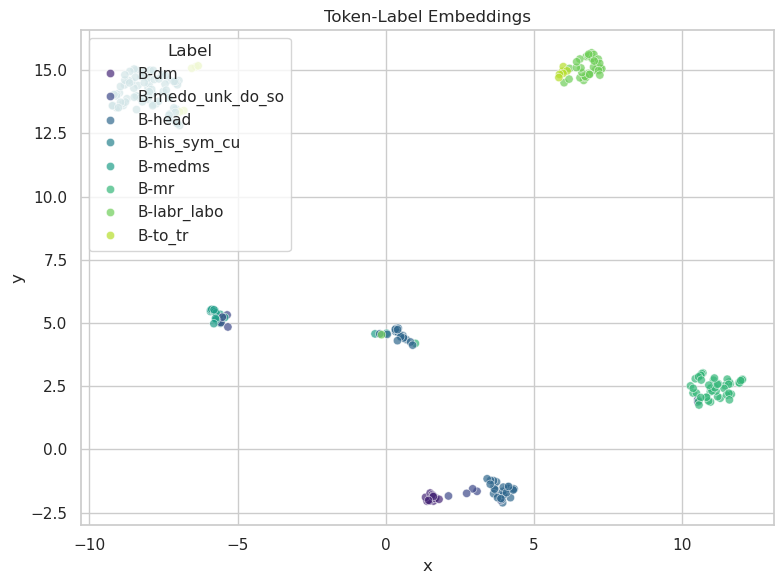

In [48]:
plot_embeddings(b_hidden_states, b_labels, title="Token-Label Embeddings", method="umap", )